#Importing Libraries

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Input, Add, Activation, concatenate,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

#Loading Dataset

In [13]:
dataset,info = tfds.load("oxford_iiit_pet:3.*.*",with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXWLYCB/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXWLYCB/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


#Pre-processing

In [14]:
def load_and_normalize(data):
  input_image = tf.image.resize(data["image"],(128,128))
  input_mask = tf.image.resize(data["segmentation_mask"],(128,128))

  input_image = tf.cast(input_image, tf.float32)/255
  input_mask -=1
  return (input_image,input_mask)

In [15]:
train = dataset["train"].map(load_and_normalize)
test = dataset["test"].map(load_and_normalize)

#Creating Batches

In [16]:
train = train.cache().shuffle(500).batch(64).repeat() #batchsize 64
test = test.batch(64)

#Ploting the images with its mask

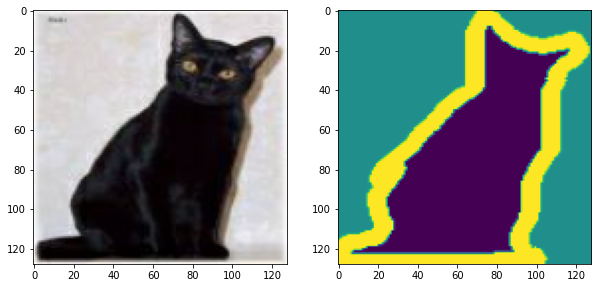

In [17]:
for images, masks in train.take(1):
  image0, masks0 = images[0], masks[0]
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(tf.keras.utils.array_to_img(image0))
plt.subplot(1,2,2)
plt.imshow(tf.keras.utils.array_to_img(masks0))
plt.show()

In [18]:
def fcn8(input_shape = (128,128,3)):
  #Encoder Start
  input_layer = Input(shape = input_shape)
  x = Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu")(input_layer)
  x = Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu")(x)
  p1 = MaxPooling2D(pool_size=(2,2), strides = 2)(x)

  x = Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = "relu")(p1)
  x = Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = "relu")(x)
  p2 = MaxPooling2D(pool_size=(2,2), strides = 2)(x)

  x = Conv2D(filters = 256, kernel_size = 3, padding = "same", activation = "relu")(p2)
  x = Conv2D(filters = 256, kernel_size = 3, padding = "same", activation = "relu")(x)
  x = Conv2D(filters = 256, kernel_size = 3, padding = "same", activation = "relu")(x)
  p3 = MaxPooling2D(pool_size=(2,2), strides = 2)(x)

  x = Conv2D(filters = 512, kernel_size = 3, padding = "same", activation = "relu")(p3)
  x = Conv2D(filters = 512, kernel_size = 3, padding = "same", activation = "relu")(x)
  x = Conv2D(filters = 512, kernel_size = 3, padding = "same", activation = "relu")(x)
  p4 = MaxPooling2D(pool_size=(2,2), strides = 2)(x)

  x = Conv2D(filters = 512, kernel_size = 3, padding = "same", activation = "relu")(p4)
  x = Conv2D(filters = 512, kernel_size = 3, padding = "same", activation = "relu")(x)
  x = Conv2D(filters = 512, kernel_size = 3, padding = "same", activation = "relu")(x)
  p5 = MaxPooling2D(pool_size=(2,2), strides = 2)(x)

  #Encoder End

  #Decoder Start
  y = Conv2DTranspose(filters = 3,kernel_size = 2, strides = 2)(p5)
  p4 = Conv2D(filters = 3, kernel_size = 1, activation = "relu", padding = "same")(p4)

  y = Add()([y,p4])


  y = Conv2DTranspose(filters = 3, kernel_size = 2, strides = 2)(y)
  p3 = Conv2D(filters = 3, kernel_size = 1, activation = "relu", padding = "same")(p3)

  y = Add()([y,p3])
  output = Conv2DTranspose(filters = 3, kernel_size = 8, strides = 8)(y)
  output_layer = Activation("softmax")(output)

  fcn8 = Model(inputs = input_layer, outputs = output_layer)
  return fcn8

In [ ]:
model = fcn8()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [22]:
training_steps = info.splits["train"].num_examples//64
validation_steps = info.splits["test"].num_examples//64

In [ ]:
model.compile(optimizer = "rmsprop", loss = "sparse_categorical_crossentropy",metrics = ["accuracy"])
model.fit(train, epochs = 5,steps_per_epoch=training_steps,validation_steps = validation_steps,validation_data = test)

Epoch 1/5
57/57 [==============================] - 27s 451ms/step - loss: 0.8358 - accuracy: 0.7044 - val_loss: 0.6235 - val_accuracy: 0.7403
Epoch 2/5
57/57 [==============================] - 25s 450ms/step - loss: 0.6472 - accuracy: 0.7302 - val_loss: 0.6380 - val_accuracy: 0.7290
Epoch 3/5
57/57 [==============================] - 27s 477ms/step - loss: 0.6161 - accuracy: 0.7440 - val_loss: 0.6038 - val_accuracy: 0.7322
Epoch 4/5
57/57 [==============================] - 25s 443ms/step - loss: 0.5881 - accuracy: 0.7546 - val_loss: 0.5584 - val_accuracy: 0.7706
Epoch 5/5
57/57 [==============================] - 25s 445ms/step - loss: 0.5619 - accuracy: 0.7678 - val_loss: 0.7729 - val_accuracy: 0.6865


#Actual Image, Mask, Predicted Mask

In [ ]:
image1= image0
image1 = image1[np.newaxis,...]
pred = model.predict(image1)
pred_mask = tf.argmax(pred[0], axis=-1)
pred_mask = pred_mask[..., tf.newaxis]

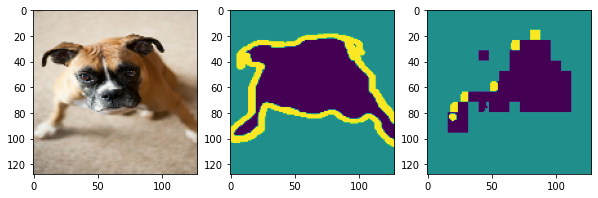

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(tf.keras.utils.array_to_img(image0))
plt.subplot(1,3,2)
plt.imshow(tf.keras.utils.array_to_img(masks0))
plt.subplot(1,3,3)
plt.imshow(tf.keras.utils.array_to_img(pred_mask))
plt.show()

#UNET

In [19]:
def UNET(input_shape = (128,128,3)):

  #Encoder Block
  input_layer = Input(shape = input_shape)
  
  x = Conv2D(filters = 64, kernel_size = 3, activation = "relu", padding = "same")(input_layer)
  s1 = Conv2D(filters = 64, kernel_size = 3, activation = "relu", padding = "same")(x)
  x = MaxPooling2D(pool_size = (2,2))(s1)

  x = Conv2D(filters = 128, kernel_size = 3, activation = "relu", padding = "same")(x)
  s2 = Conv2D(filters = 128, kernel_size = 3, activation = "relu", padding = "same")(x)
  x = MaxPooling2D(pool_size = (2,2))(s2)

  x = Conv2D(filters = 256, kernel_size = 3, activation = "relu", padding = "same")(x)
  s3 = Conv2D(filters = 256, kernel_size = 3, activation = "relu", padding = "same")(x)
  x = MaxPooling2D(pool_size = (2,2))(s3)

  x = Conv2D(filters = 512, kernel_size = 3, activation = "relu", padding = "same")(x)
  s4 = Conv2D(filters = 512, kernel_size = 3, activation = "relu", padding = "same")(x)
  x = MaxPooling2D(pool_size = (2,2))(s4)

  #Bottleneck
  x = Conv2D(filters = 1024, kernel_size = 3, activation = "relu",padding = "same")(x)
  s5 = Conv2D(filters = 1024, kernel_size = 3, activation = "relu",padding = "same")(x)

  # Decoder Block
  y = Conv2DTranspose(filters =512 , kernel_size =3, strides = 2, padding = "same")(s5)
  c1 = concatenate([y,s4])
  y = Dropout(0.3)(c1)

  y = Conv2D(512, kernel_size = 3, activation = "relu", padding = "same")(y)
  y = Conv2D(512, kernel_size = 3, activation = "relu", padding = "same")(y)

  y = Conv2DTranspose(filters =256 , kernel_size =3, strides = 2, padding = "same")(y)
  c2 = concatenate([y,s3])
  y = Dropout(0.3)(c2)

  y = Conv2D(256, kernel_size = 3, activation = "relu", padding = "same")(y)
  y = Conv2D(256, kernel_size = 3, activation = "relu", padding = "same")(y)

  y = Conv2DTranspose(filters =128 , kernel_size =3, strides = 2, padding = "same")(y)
  c3 = concatenate([y,s2])
  y = Dropout(0.3)(c3)

  y = Conv2D(128, kernel_size = 3, activation = "relu", padding = "same")(y)
  y = Conv2D(128, kernel_size = 3, activation = "relu", padding = "same")(y)

  y = Conv2DTranspose(filters =64 , kernel_size =3, strides = 2, padding = "same")(y)
  c4 = concatenate([y,s1])
  y = Dropout(0.3)(c4)

  y = Conv2D(64, kernel_size = 3, activation = "relu", padding = "same")(y)
  y = Conv2D(64, kernel_size = 3, activation = "relu", padding = "same")(y)
  
  output_layer = Conv2D(filters = 3, kernel_size = 1, activation = "softmax")(y)


  model = Model(inputs = input_layer, outputs = output_layer)
  return model

In [20]:
unet = UNET()
unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_77 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_76[0][0]']              
                                )                                                           

In [23]:
unet.compile(optimizer = "rmsprop", loss = "sparse_categorical_crossentropy",metrics = ["accuracy"])
unet.fit(train, epochs = 5,steps_per_epoch=training_steps,validation_steps = validation_steps,validation_data = test)

Epoch 1/5
57/57 [==============================] - 98s 1s/step - loss: 1.7999 - accuracy: 0.5671 - val_loss: 1.4438 - val_accuracy: 0.5730
Epoch 2/5
57/57 [==============================] - 76s 1s/step - loss: 0.9180 - accuracy: 0.5788 - val_loss: 0.9304 - val_accuracy: 0.5730
Epoch 3/5
57/57 [==============================] - 68s 1s/step - loss: 1.0523 - accuracy: 0.5619 - val_loss: 0.8645 - val_accuracy: 0.5730
Epoch 4/5
57/57 [==============================] - 68s 1s/step - loss: 0.9197 - accuracy: 0.5766 - val_loss: 0.8358 - val_accuracy: 0.5730
Epoch 5/5
57/57 [==============================] - 68s 1s/step - loss: 0.8548 - accuracy: 0.5855 - val_loss: 0.7894 - val_accuracy: 0.5747


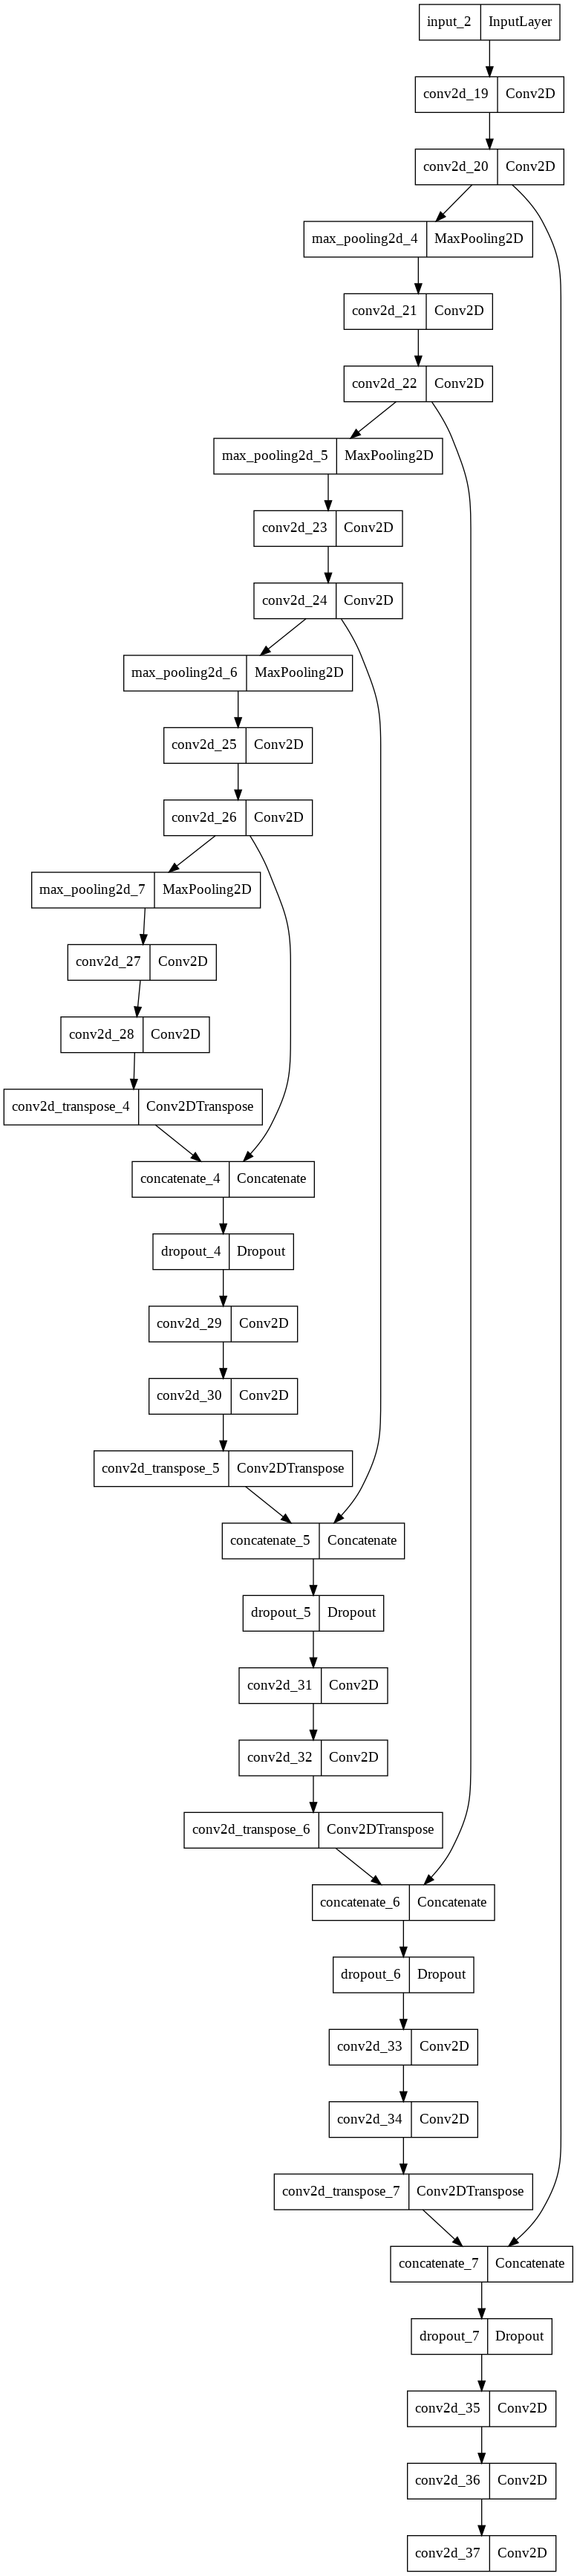

In [7]:
plot_model(unet)

In [24]:
image1= image0
image1 = image1[np.newaxis,...]
pred = unet.predict(image1)
pred_mask = tf.argmax(pred[0], axis=-1)
pred_mask = pred_mask[..., tf.newaxis]

1/1 [==============================] - 1s 1s/step


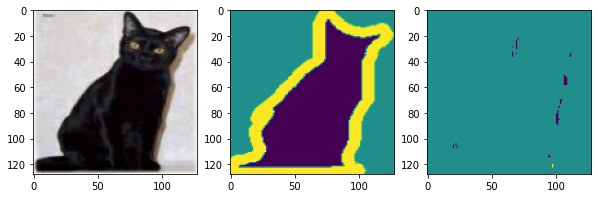

In [25]:
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(tf.keras.utils.array_to_img(image0))
plt.subplot(1,3,2)
plt.imshow(tf.keras.utils.array_to_img(masks0))
plt.subplot(1,3,3)
plt.imshow(tf.keras.utils.array_to_img(pred_mask))
plt.show()